In this example, we used MLP as part of the time-series model for retail sales using 16 past data points and predicting for the current time period.

In [13]:

#matplotlib is for visualization and plotting the graphs

#tensorflow is for setting up the neural network

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
#matplotlib inline is for establishing the plots with parameters style, palette, font_scale and setting the figure size to 16 units by 10 units, where 16 units is the width and 10 units is the height

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 16, 10

In [14]:
#Loading the dataset for Retail Sales for The Past Year using the timeSeriesUploadedFiles variable and the upload function for the files from the import statement from google.colab import files
#This code is for uploading the retail sales dataset as part of a csv file
from google.colab import files
timeSeriesUploadedFiles = files.upload()

In [15]:

#Using the modifiedDataFrame variable and assigning it to the read_csv function in pandas to read the contents of the file RSXFSN.csv. 
#Reading the RSXFSN dataset into Pandas DataFrame

modifiedDataFrame = pd.read_csv("/content/RSXFSN.csv")

In [17]:

#Maintaining only the RSXFSN column in the final dataset for representing and visualizing the dataset
#The preservingTimeSeriesColumns preserves the RSXFSN column across the entire dataset

preservingTimeSeriesColumns = ['RSXFSN']
modifiedDataFrame = modifiedDataFrame[preservingTimeSeriesColumns]

#Rescaling the dataset to make the entire dataset values as a fraction, dividing every individual dataset value by 10000

modifiedDataFrame = modifiedDataFrame / 10000

In [18]:

#80% of dataset is training data with the numberTrainingData variable assigned to len(modifiedDataFrame) * 0.8 to denote 80% of data residing in training data

numberTrainingData = int(len(modifiedDataFrame) * 0.8)

#Remaining 20% of dataset is testing data with numberTestingData variable assigned to len(modifiedDataFrame) - numberTrainingData to denote 20% of data residing in testing data

numberTestingData = len(modifiedDataFrame) - numberTrainingData

#The training data of this real estate dataset is represented in the range from 0 to numberTrainingData and the testing data of this real estate dataset is represented in the range from numberTrainingData to the length of the variable modifiedDataFrame
#In essence, there is a partition: one partition for the training data and one for the testing data

timeSeriesTraining, timeSeriesTesting = modifiedDataFrame.iloc[0:numberTrainingData], modifiedDataFrame.iloc[numberTrainingData:len(modifiedDataFrame)]

#This line of code prints the total length of the timeSeriesTraining and the timeSeriesTesting, both of which are derived from the preceding step. Also, timeSeriesTraining is significantly greater than timeSeriesTesting, exactly 4 times as much since 80% of the dataset is training and 20% is testing
#Changing the percentage of training data from 80% to 75% or 70% will thereby affect the length of the timeSeriesTraining and timeSeriesTesting accordingly
print(len(timeSeriesTraining), len(timeSeriesTesting))

300 75


In [19]:

#This function realEstateTimeSeries slices the time series model to prepare for a neural network
#A single column of time series data can be expanded into as many trainingSteps as required and have the data in the a be unfolded in multiple columns
#In this function, the parameters for the realEstateTimeSeries function are a and numberTrainingSteps = 1.
#The trainingSet for a and the trainingSet for b are both initialized to an empty array.
#The trainingIndex is in the range of the length of parameter a minus the number of training steps
#Within this function, variable g is set to the integer location of a with the trainingIndex consisting of the sum of the values of the trainingIndex and the number of training steps
#The first training set (a_trainingSet) is appended to variable g after this iloc operation in g
#Subsequently, variable h is initialized to the integer location of a with the sum of the trainingIndex and the number of training steps
#The second training set (b_trainingSet) is appended to variable h after this iloc operation in h
#The final step is to return two numpy arrays: one with the first training set (a_trainingSet) and another with the second training set (b_trainingSet)

def realEstateTimeSeries(a, numberTrainingSteps = 1):
  a_trainingSet, b_trainingSet = [], []
  for trainingIndex in range(len(a) - numberTrainingSteps):
    g = a.iloc[trainingIndex: (trainingIndex + numberTrainingSteps)].values
    a_trainingSet.append(g)
    h = a.iloc[trainingIndex + numberTrainingSteps].values
    b_trainingSet.append(h)
  return np.array(a_trainingSet), np.array(b_trainingSet)

In [20]:

#There are 16 past number training steps to predict the next month's retail sales
#In essence, 16 past training steps data points are used to predict the subsequent month's retail sales. A prediction is made based on multiple correlated data points collected across a time series model.
#It is possible to use multiple time series model in a given dataset, however, in this analysis, we are only using a single time series model.
#If we are using a multiple time series model, there would be 3 dimensions required: samples, n_steps, and n_features.

numberTrainingSteps = 16
numberTrainingFeatures = 1

#The two time series training data, timeSeriesTraininga and timeSeriesTrainingb, both are invoked using the realEstateTimeSeries function with parameters timeSeriesTraining and numberTrainingSteps.
#Similarly, the two time series testing data, timeSeriesTestinga and timeSeriesTestingb, both are invoked using the realEstateTimeSeries function with parameters timeSeriesTesting and numberTrainingSteps.

timeSeriesTraininga, timeSeriesTrainingb = realEstateTimeSeries(timeSeriesTraining, numberTrainingSteps)
timeSeriesTestinga, timeSeriesTestingb = realEstateTimeSeries(timeSeriesTesting, numberTrainingSteps)

#Finally, the shape of the first timeSeriesTraining (timeSeriesTraininga.shape) and the shape of the second timeSeriesTraining (timeSeriesTrainingb.shape) are printed to indicate the dimensions of the two training set arrays
#There are 284 rows, 16 time steps, and only 1 feature exists for the timeSeriesTraininga. 
#There are 284 rows and only 1 feature exists for the timeSeriesTrainingb.

#Also, the shape of the first timeSeriesTesting (timeSeriesTestinga.shape) and the shape of the second timeSeriesTesting (timeSeriesTestingb.shape) are printed to indicate the dimensions of the two testing set arrays
#There are 59 rows, 16 time steps, and only 1 feature exists for the timeSeriesTestinga.
#There are 59 rows and only 1 feature exists for the timeSeriesTestingb.
print(timeSeriesTraininga.shape, timeSeriesTrainingb.shape)
print(timeSeriesTestinga.shape, timeSeriesTestingb.shape)


(284, 16, 1) (284, 1)
(59, 16, 1) (59, 1)


In [21]:

#We are using Sequential Method for the timeSeriesModelValue since we are only dealing with a simple neural network structure.

timeSeriesModelValue = tf.keras.Sequential()
timeSeriesModelValue.add(tf.keras.layers.Flatten())

#Using Dense layer with 50 nodes and Rectified Linear Unit for the activation layer and setting the input_dimensions parameter to the number of training steps, which in our case, is 16.

timeSeriesModelValue.add(Dense(50, activation = 'relu', input_dim  = numberTrainingSteps))

#Invoking the first layer of the neural network in the Dense layer to the timeSeriesModelValue

timeSeriesModelValue.add(Dense(1))

#The loss of the timeSeriesModelValue is the mean squared error with Adam as the optimizer parameter

timeSeriesModelValue.compile(loss = 'mean_squared_error', optimizer = Adam(0.001))


In [22]:

#Using the fit command to fit the neural network and setting the first and second training data with timeSeriesTraininga and timeSeriesTrainingb as parameter and number of epochs to 500 and a batch size of 32, with a validation split of 0.1

#timeSeriesModelHistory is equivalent to timeSeriesModelValue and the fit function with timeSeriesTraininga, timeSeriesTrainingb and other parameters as well

timeSeriesModelHistory = timeSeriesModelValue.fit(timeSeriesTraininga, timeSeriesTrainingb, epochs = 500, batch_size = 32, validation_split = 0.1)

#After this step of training and running the timeSeriesModel, all steps and optimally weighted with the most optimal loss function after 32 batches, a validation split of 10%, and 500 epochs, or training samples, and feeding both the training time series models.

Epoch 1/500
8/8 [==============================] - 1s 36ms/step - loss: 7.5912e-06 - val_loss: 1.0884e-05
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3919e-06 - val_loss: 3.6861e-07
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5050e-06 - val_loss: 5.6676e-06
Epoch 4/500
8/8 [==============================] - 0s 10ms/step - loss: 9.5587e-07 - val_loss: 1.7951e-06
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 6.9711e-07 - val_loss: 2.0627e-06
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 4.9830e-07 - val_loss: 2.0020e-06
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 4.4178e-07 - val_loss: 1.0448e-06
Epoch 8/500
8/8 [==============================] - 0s 8ms/step - loss: 4.4631e-07 - val_loss: 1.5511e-06
Epoch 9/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9316e-07 - val_loss: 1.3705e-06
Epoch 10/500
8/8 [==============================] - 0

In [23]:

#Using the predict function for predicting the second time series (timeSeriesPredictionb) with the first time series testing value (timeSeriesTestinga) and using the timeSeriesModelValue variable, which was used in the neural network with the Dense Layer

timeSeriesPredictionb = timeSeriesModelValue.predict(timeSeriesTestinga)

2/2 [==============================] - 0s 4ms/step


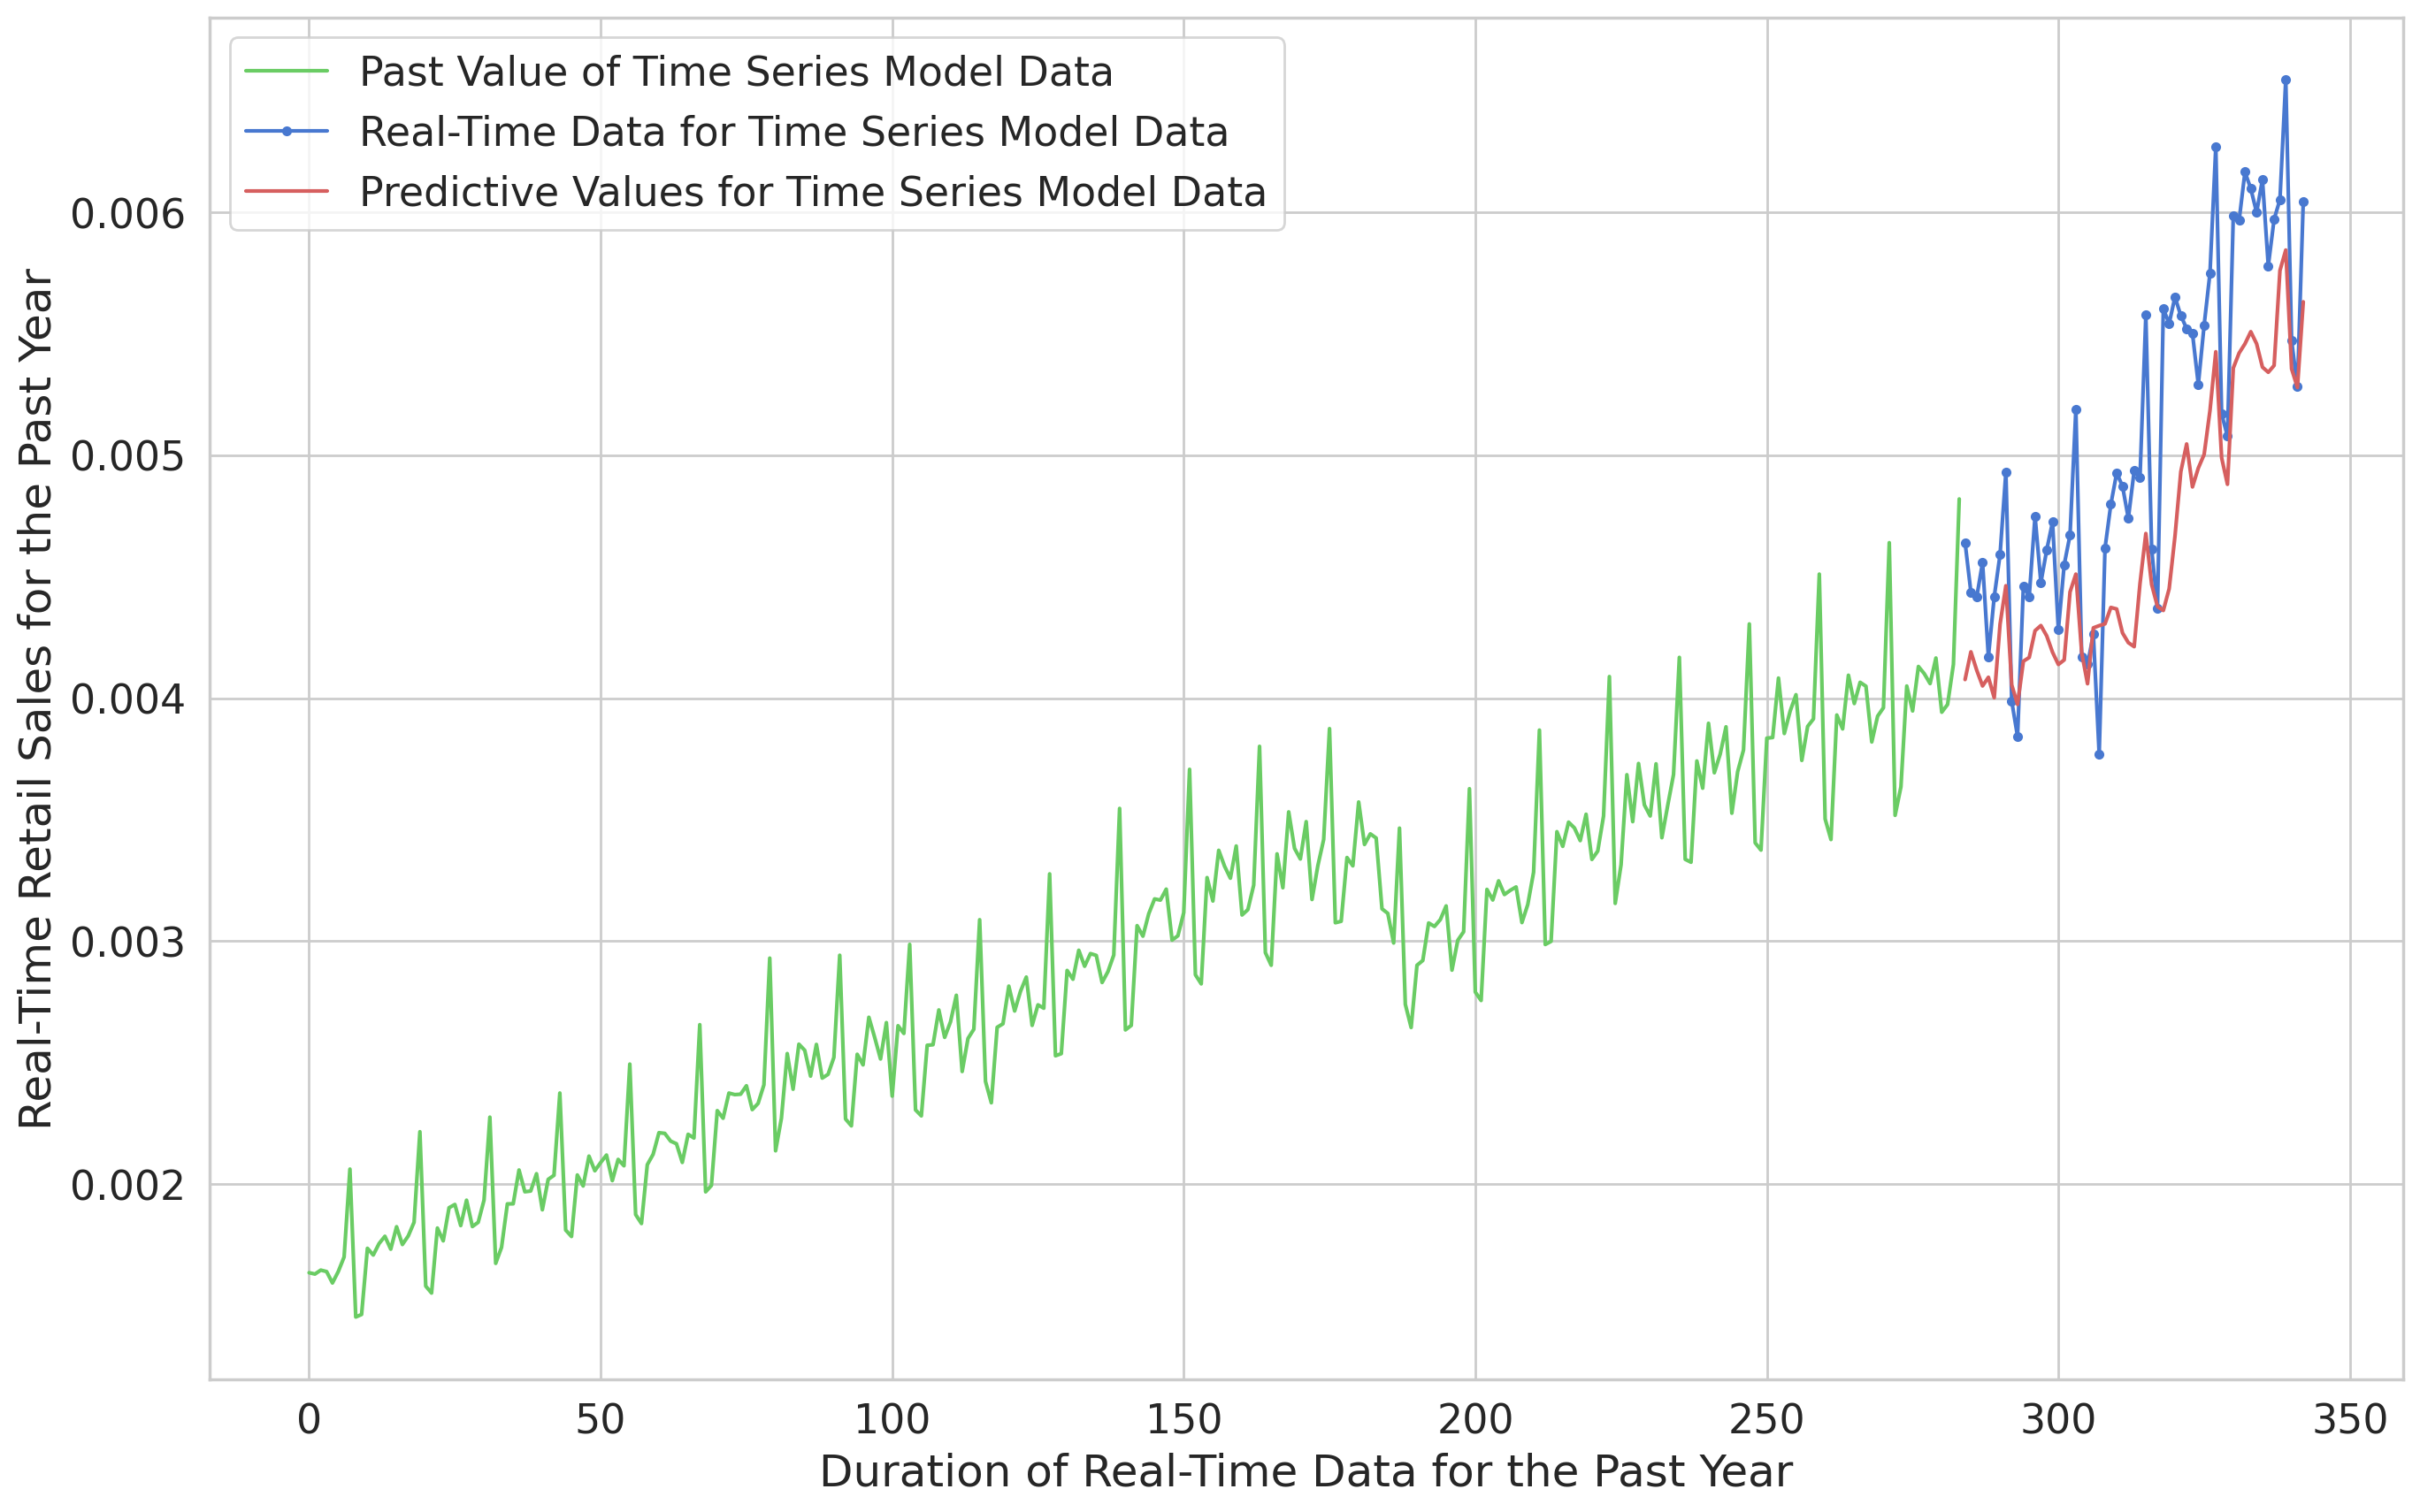

In [24]:

#Plotting the sequence of numbers in the Duration of Real-Time Data for the Past Year from 0 to 350 and the timeSeriesTrainingb
plt.plot(np.arange(0, len(timeSeriesTrainingb)), timeSeriesTrainingb, 'g', label = 'Past Value of Time Series Model Data')

#Plotting the testing data for the second variable (timeSeriesTestingb) with a marker '.' and label "Real-Time Data for Time Series Model Data"
#and the prediction for the second variable (timeSeriesPredictionb) in red with a label "Predictive Values for Time Series Model Data"

plt.plot(np.arange(len(timeSeriesTrainingb), len(timeSeriesTrainingb) + len(timeSeriesTestingb)), timeSeriesTestingb, marker='.', label="Real-Time Data for Time Series Model Data")
plt.plot(np.arange(len(timeSeriesTrainingb), len(timeSeriesTrainingb) + len(timeSeriesTestingb)), timeSeriesPredictionb, 'r', label="Predictive Values for Time Series Model Data")

#Plotting with an x label and ylabel as follows: the x label is to display the duration of real-time data for the past year and the y label displays the exact sales in retail for the past year
#Keep in mind that all this data is based on 16 past data points from previous years retail prices

plt.ylabel('Real-Time Retail Sales for the Past Year')
plt.xlabel('Duration of Real-Time Data for the Past Year')

#Plots the legend with green indicating past value of time series model data, blue with . indicating real-time data for time series model data, and red indicating predictive values for time series model data

plt.legend()

#Displays the time series plot based on all the data and neural network training evaluated earlier

plt.show()

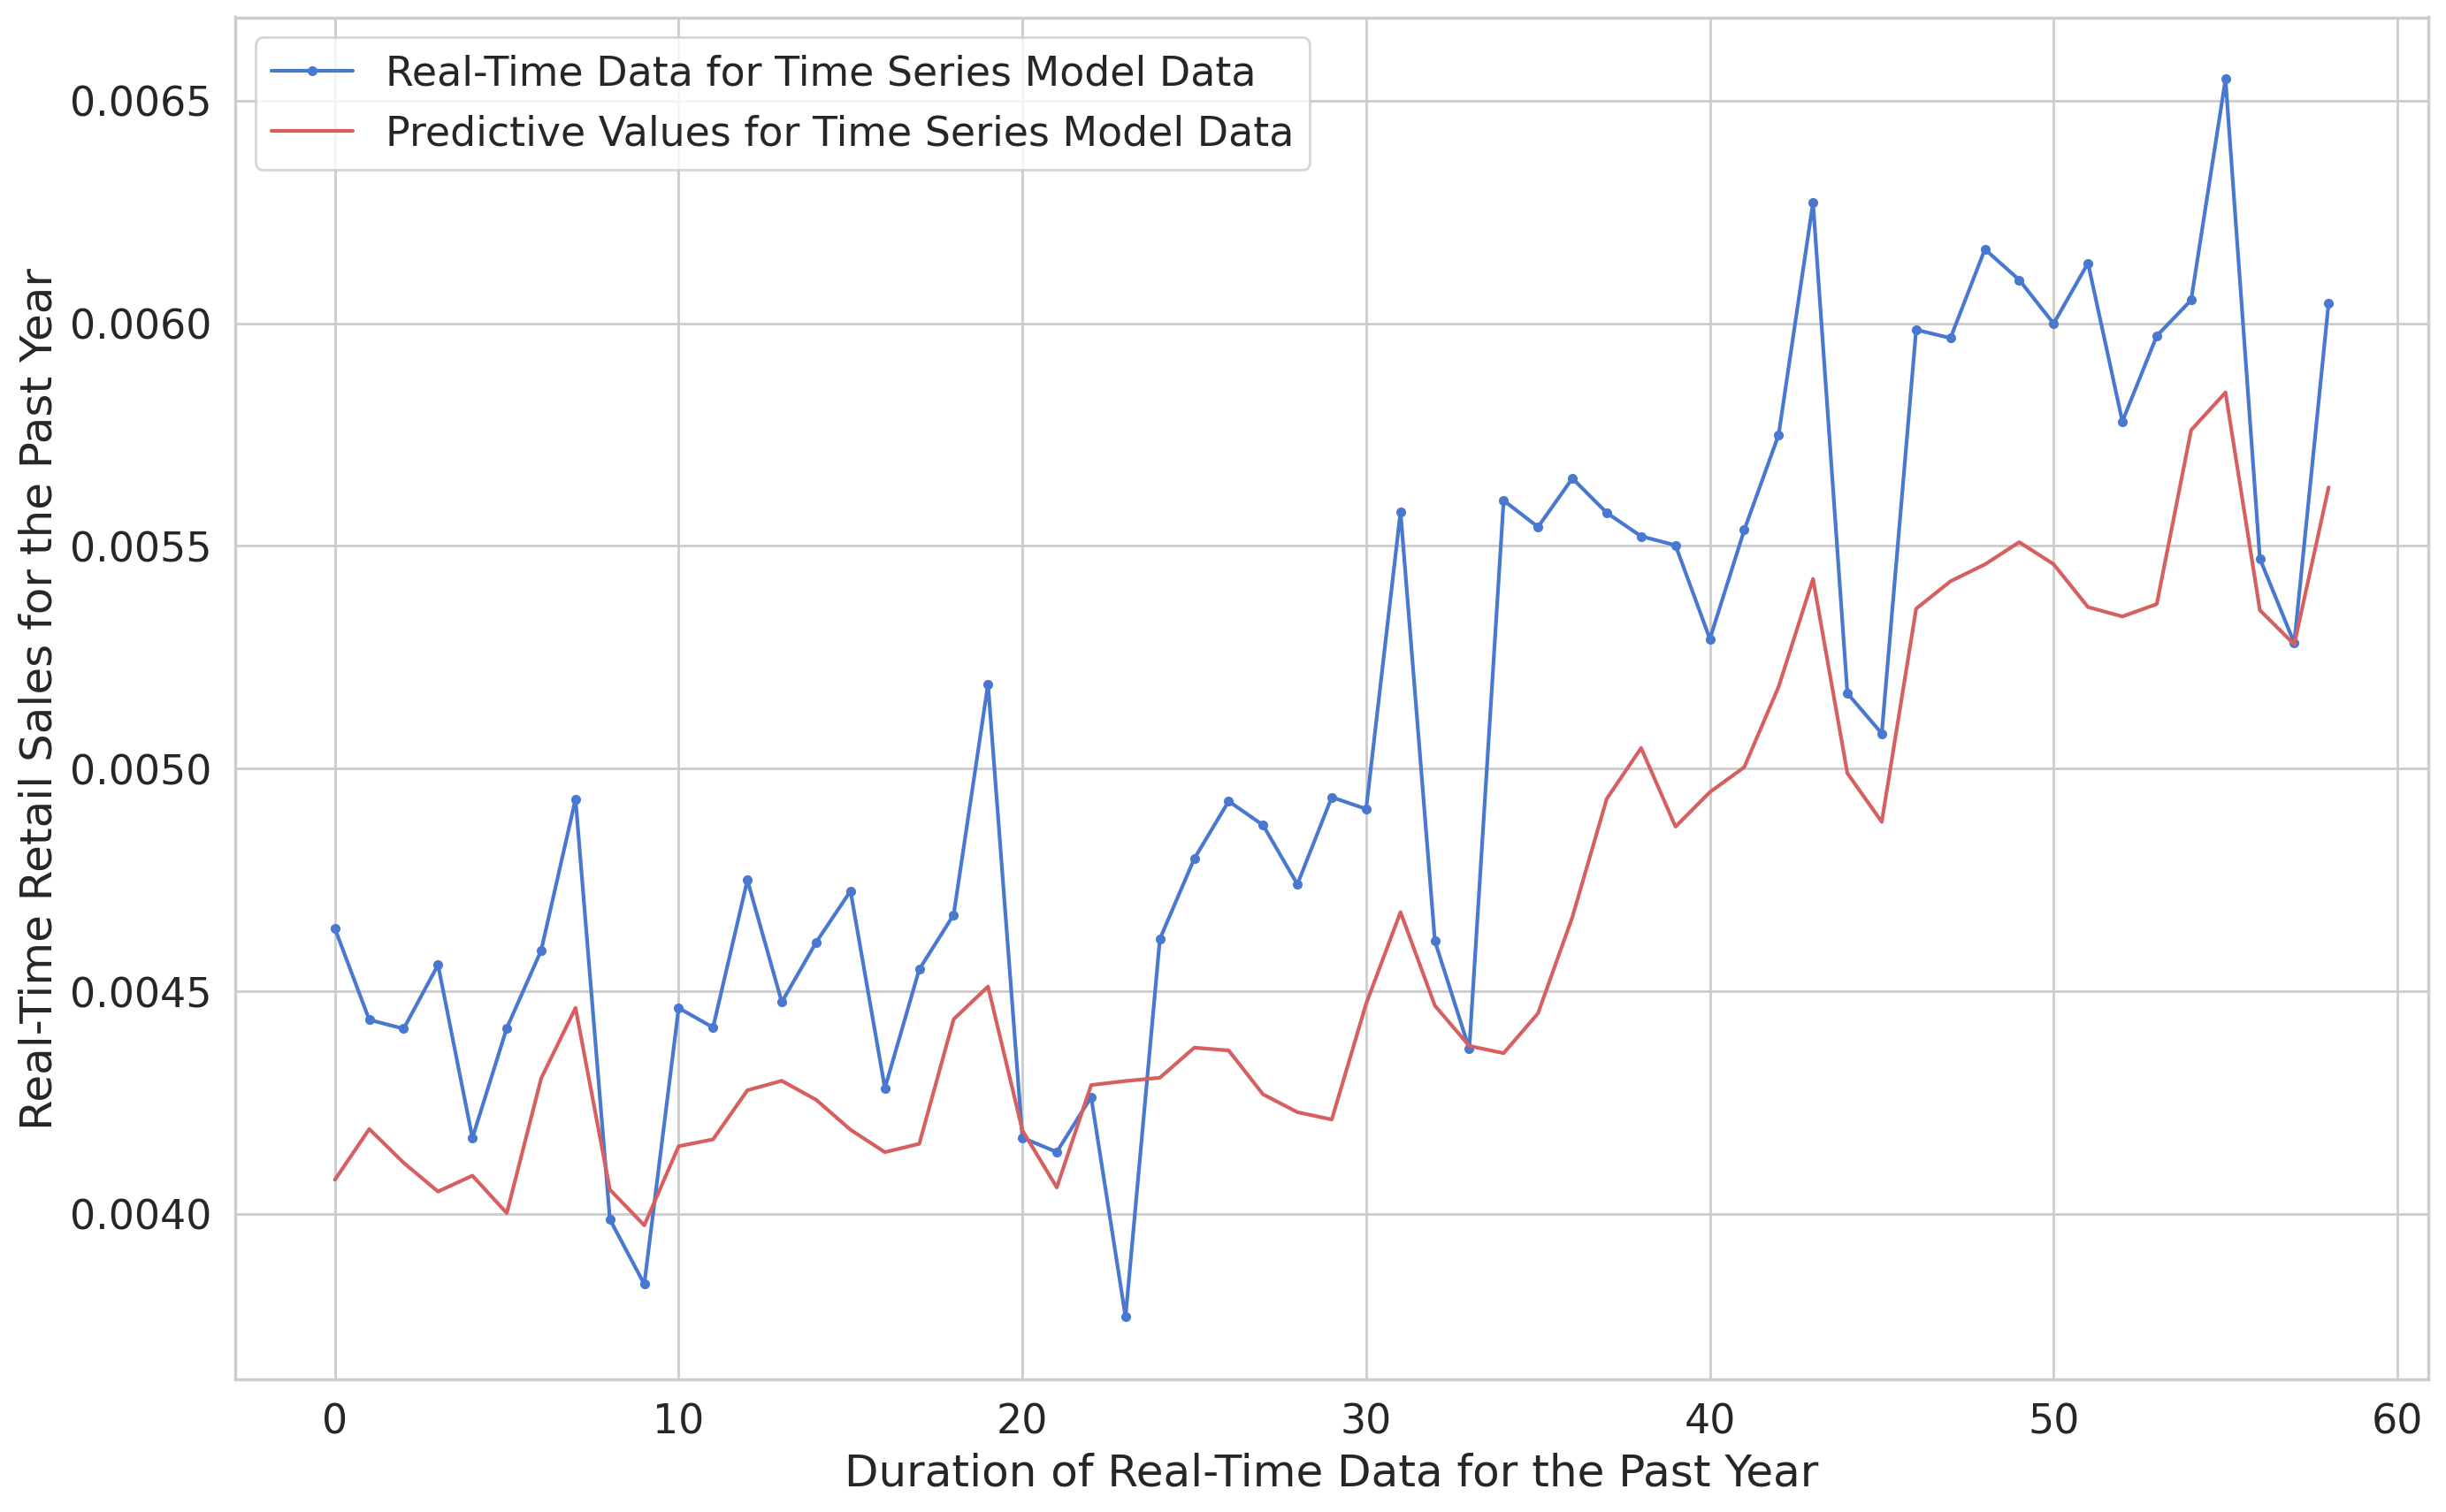

In [25]:

#This second graph is to focus only on the real-time data for time series model and the predictive values for time series model data and to not focus on the past value of time series model data in the graph above

#The blue with a . marker has the label "Real-Time Data for Time Series Model Data"

plt.plot(timeSeriesTestingb, marker = '.', label = 'Real-Time Data for Time Series Model Data')

#The red has the label "Predictive Values for Time Series Model Data"

plt.plot(timeSeriesPredictionb, 'r', label = 'Predictive Values for Time Series Model Data')

#Plotting with an x label and ylabel as follows: the x label is to display the duration of real-time data for the past year and the y label displays the exact sales in retail for the past year
#Keep in mind that all this data is based on 16 past data points from previous years retail prices

plt.ylabel('Real-Time Retail Sales for the Past Year')
plt.xlabel('Duration of Real-Time Data for the Past Year')

#Plots the legend with blue and . marker indicating real-time data for time series model data, and red indicating predictive values for time series model data

plt.legend()

#Displays the time series plot based on all the data and neural network training evaluated earlier

plt.show()

In this example, we are using CNN as part of the time-series model for retail sales using 16 past data points and predicting for the current time period instead of MLP, or Multilayer Perceptron as in preceding example.

A CNN works well for identifying simple patterns within the data which will then be used to form more complex patterns within higher layers. 

In [26]:
#Importing the Flatten, Dense, Conv1D, MaxPool1D, and Dropout Packages of the Convolutional Neural Network from the tensorflow.keras.layers library
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
import tensorflow as tf

In [27]:
#Initializing the number of epochs, or training data for the retail sales dataset and the batch size to 10 and 64, respectively
retailSalesNumEpochs = 10
retailSalesBatchSize = 64

In [29]:
#Initializing the training and testing data for the first Time Series Training and Testing Data with the reshape function and a numpy array
timeSeriesTraininga = np.array(timeSeriesTraininga).reshape(timeSeriesTraininga.shape[0], timeSeriesTraininga.shape[1], 1)
timeSeriesTestinga = np.array(timeSeriesTestinga).reshape(timeSeriesTestinga.shape[0], timeSeriesTestinga.shape[1], 1)

In [30]:
#Printing the specific shape of the timeSeriesTraining and timeSeriesTesting data which are (300, 1) and (75, 1),
#meaning there are 300 rows for the first time series training data and only 1 feature exists and there are 75 rows for the first time series testing data and only 1 feature exists

print("Shape of First Time Series Training Data: ", timeSeriesTraining.shape)
print("Shape of First Time Series Testing Data: ", timeSeriesTesting.shape)

Shape of First Time Series Training Data:  (300, 1)
Shape of First Time Series Testing Data:  (75, 1)


In [31]:
#Adding the different layers to the keras.models.Sequential for the retailPricesCNNModel dataset with Conv1D, initializing the filters from 32 to 64 to 128, 
#and adding MaxPool1D, Dropout, Flatten, and Dense with the softmax and Leaky Rectified Linear Unit activation layers
retailPricesCNNModel = tf.keras.models.Sequential()
retailPricesCNNModel.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (timeSeriesTraininga.shape[1],1)))
retailPricesCNNModel.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
retailPricesCNNModel.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
retailPricesCNNModel.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
retailPricesCNNModel.add(Dropout(0.5))
retailPricesCNNModel.add(Flatten())
retailPricesCNNModel.add(Dense(units = 256, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
retailPricesCNNModel.add(Dense(units = 512, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
retailPricesCNNModel.add(Dense(units = 5, activation='softmax'))

In [32]:
#Optimizing the dataset in the retailPricesCNNModel with adam and setting the loss function to sparse_categorical_crossentropy with the evaluation metrics measuring the accuracy of the retail dataset
retailPricesCNNModel.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
#Evaluating the summary of the retail prices CNN Model with the total number of parameters, 427,589 and all of them serving as trainable and none of them serving
#as non-trainable parameters (427,589 total trainable parameters)

#128 + 6208 + 24704 parameters are Conv1D, 0 are MaxPooling1D, Dropout, and Flatten while the majority of the trainable parameters are in Dense Layer 
#of the Activation Layer of the Convolutional Neural Network
retailPricesCNNModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 128)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                      

In [34]:

#Running the 10 total epochs against the 2 timeSeriesTraining datasets with batch size of 64 and the validation dataset constituting of the 
#2 timeSeriesTesting datasets all with the fit function to fit the model dataset

retailPricesModelHistory = retailPricesCNNModel.fit(timeSeriesTraininga, timeSeriesTrainingb, batch_size=retailSalesBatchSize, epochs=retailSalesNumEpochs, 
		verbose=1, validation_data=(timeSeriesTestinga, timeSeriesTestingb))

Epoch 1/10
5/5 [==============================] - 3s 140ms/step - loss: 1.5451 - accuracy: 0.0000e+00 - val_loss: 1.2859 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 54ms/step - loss: 0.8882 - accuracy: 0.0000e+00 - val_loss: 0.0877 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 51ms/step - loss: 0.0242 - accuracy: 0.0000e+00 - val_loss: 4.7684e-07 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 49ms/step - loss: 1.1543e-07 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 52ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 54ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - accur

In [35]:

#Running the evaluate function for the retailPricesScore

retailPricesScore = retailPricesCNNModel.evaluate(timeSeriesTestinga, timeSeriesTestingb, verbose = 0)

#Printing the Retail Dataset Testing Loss and Accuracy, each of which come to 0.0, with optimal loss function compared to MLP, which had greater loss

print('Retail Data Set Test Loss: ',  retailPricesScore[0])
print('Retail Data Set Test Accuracy: ', retailPricesScore[1])

Retail Data Set Test Loss:  0.0
Retail Data Set Test Accuracy:  0.0


Both MLP and CNN can be utilized for time series forecasting model, however, MLP takes a vector as an input while CNN takes a tensor as an input. CNN can evaluate spatial relation between pixels in a much more sophisticated way compared to MLP.

Also, the weights of CNN are small and shared, making CNN less wasteful and easier to train than MLP and more effective too. CNN also has the potential to go deeper! 

MLP is also deemed much more inefficient for modern computer vision tasks compared to CNN. 

As evidenced in this dataset, the retail dataset loss and accuracy for CNN is exactly 0.0 while MLP has a small amount of loss function even afer running 500 epochs. As discussed earlier, the weights of CNN are small and shared, with the number of epochs used in CNN only amounting to 10, and still managing to produce infinitesimal loss, or extremely small loss. In fact, there was 0 loss in this CNN model. MLP had a loss of 7.4797 * 10^-8 and a validation loss of 
1.1264 * 10-7, even after 500 epochs were performed on this retail dataset.

However, MLP uses backpropagation for training the network and has a default learning rate of 0.01. Learning in MLPs also consists in adjusting its perceptrons' weights so as to provide low error on the training data. MLP can also be classified as a deep learning architecture since there are multiple layers of neurons. A MLP can handle linearly separable and non-linearly separable data while the traditional perceptron was only capable of handling linearly separable data, hence the reason why MLP was introduced to overcome this limitation. 

MLP is best suited for classification prediction problems where inputs are assigned a class or label. They are also suitable for regression prediction problems where a real-valued quantity is predicted given a set of inputs. MLP is a supervised learning algorithm that learns a function by training on a dataset, which in this case is retail sales dataset. 

CNN, however, is more advantageous to utilize compared to MLP for this retail sales dataset for the following reasons:

Utilzing CNN for this time series forecasting model will reduce the number of units in the network, thereby requiring fewer parameters for learning and reducing the chance of overfitting from occurring within this retail sales dataset. 

Also, CNN is more suitable for this time-series forecasting model since it offers dilated convolutions, in which filters can be used to compute dilations between cells.